In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

! git clone https://github.com/tanmayi2/CoffeeDataAnalysis-LCL repo-files

fatal: destination path 'repo-files' already exists and is not an empty directory.


# Coffee Reviews Data Analysis
Using Coffee Reviews Data from [this Kaggle dataset](https://www.kaggle.com/datasets/schmoyote/coffee-reviews-dataset)

In [13]:
data = pd.read_csv("repo-files/data/simplified_coffee.csv")
print(data.head(10))

                               name                     roaster         roast  \
0          Ethiopia Shakiso Mormora                Revel Coffee  Medium-Light   
1                Ethiopia Suke Quto                 Roast House  Medium-Light   
2        Ethiopia Gedeb Halo Beriti   Big Creek Coffee Roasters        Medium   
3           Ethiopia Kayon Mountain  Red Rooster Coffee Roaster         Light   
4  Ethiopia Gelgelu Natural Organic   Willoughby's Coffee & Tea  Medium-Light   
5            Ethiopia Hambela Alaka   Black Oak Coffee Roasters  Medium-Light   
6           Organic Ethiopia Kirite          Wonderstate Coffee  Medium-Light   
7                   Ethiopia Sidama       Reunion Island Coffee        Medium   
8             Decaf Ethiopia Sidamo                Old Soul Co.        Medium   
9    Ethiopia Yirgacheffe Washed G1                      A.R.C.  Medium-Light   

     loc_country    origin  100g_USD  rating    review_date  \
0  United States  Ethiopia      4.70      92 

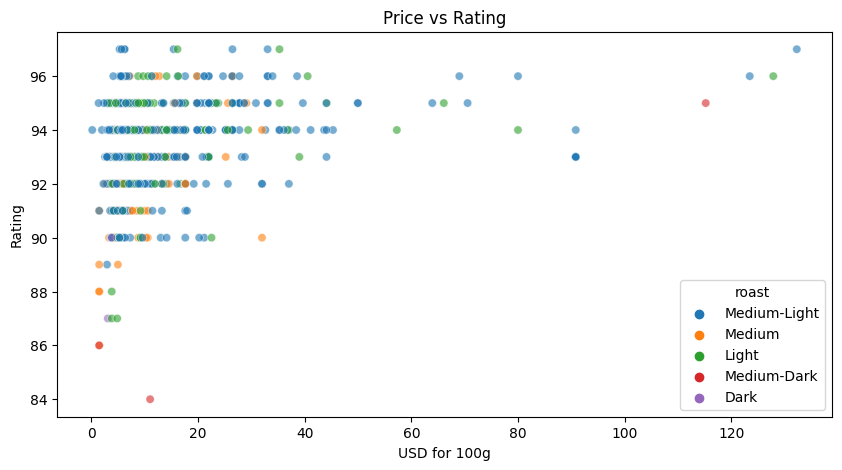

In [14]:
#Price vs Rating Scatterplot
fig = plt.figure(figsize=(10,5))
sns.scatterplot(
    data=data,
    y='rating',
    x='100g_USD',
    alpha=0.6,
    hue="roast"
)
plt.title("Price vs Rating")
plt.ylabel('Rating')
plt.xlabel('USD for 100g')
plt.show()

Insights: There's a cluster of blue and green points near the sweet spot of high rating + low price --> Ratings for Medium-Light and Light roasts tend to be more positive. This makes sense as Medium-Light and Light roasts are most common for a wide consumer audience. Niche roasts can get more pricey and less liked because they do best with a niche audience.

<Figure size 1000x500 with 0 Axes>

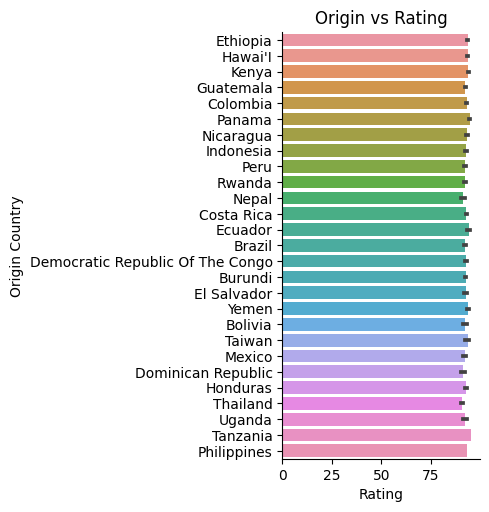

In [15]:
#Origin vs Rating --> Catplot for each origin
fig = plt.figure(figsize=(10,5))
sns.catplot(
    data=data,
    x='rating',
    y='origin',
    kind="bar"
)
plt.title("Origin vs Rating")
plt.xlabel('Rating')
plt.ylabel('Origin Country')
plt.show()

<Figure size 1000x500 with 0 Axes>

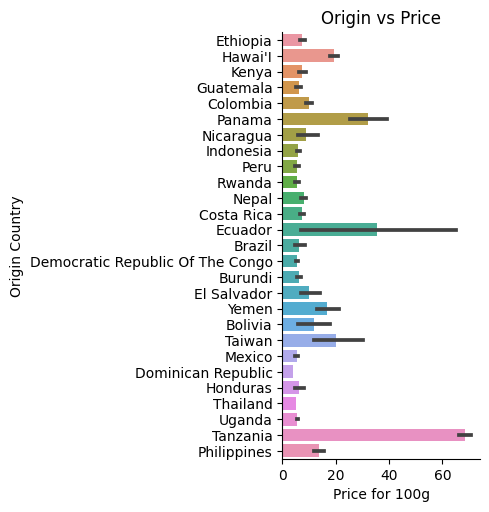

In [16]:
#Origin vs Price --> Catplot for each loc
fig = plt.figure(figsize=(10,5))
sns.catplot(
    data=data,
    x='100g_USD',
    y='origin',
    kind="bar"
)
plt.title("Origin vs Price")
plt.xlabel('Price for 100g')
plt.ylabel('Origin Country')
plt.show()

Insights: The ratings based on origin country aren't that varied, however the price can drastically differ. Therefore, sourcing coffee from countries like Indonesia, Peru, Rwanda, and Mexico may be the best bet since their prices are lower and their ratings are still comparable to more expensive coffees from Tanzania, Ecuador, and Panama.

# Coffee Reviews ML Model
Using the same data from [this Kaggle dataset](https://www.kaggle.com/datasets/schmoyote/coffee-reviews-dataset) to create a model that predicts reasonable coffee ratings

##Prepare Data

In [47]:
! pip install feature-engine
! pip install catboost

In [57]:
from feature_engine.encoding import RareLabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import Pool, CatBoostRegressor

In [50]:
data = pd.read_csv("repo-files/data/simplified_coffee.csv")
print(data.shape)
data.sample(n=5)

(1246, 9)


,name,roaster,roast,loc_country,origin,100g_USD,rating,review_date,review
373,Ethiopia Natural Yirgacheffe Blue Donkey Lot #2,Kakalove Cafe,Medium-Light,Taiwan,Ethiopia,4.25,94,November 2019,"Delicate, berry-toned, deeply sweet. Wild stra..."
346,Colombia Finca El Paraiso Double Anaerobic Geisha,Lucky Cafe,Medium-Light,Taiwan,Colombia,25.60,92,November 2019,"Bright, intensely pungent, oddly engaging. Spe..."
1029,Uluwehi Farm Kona SL34 Yeast-Fermentation Wash...,Paradise Roasters,Medium-Light,United States,Hawai'I,35.27,94,February 2022,"Richly sweet, deeply layered. Lychee, tangerin..."
612,Ethiopia Sidama Bona Washed G1,Singsun Coffee,Medium-Light,Taiwan,Ethiopia,12.79,94,October 2020,"Sweetly pungent, complex. Apricot, cocoa nib, ..."
212,Ethiopia Kochere Washed Saona Lot,Kakalove Cafe,Medium-Light,Taiwan,Ethiopia,4.11,95,December 2018,"High-toned, richly sweet-tart. Apricot, wild h..."


In [51]:
# select label
main_label = 'rating'

# extract review_date year
data['review_date'] = data['review_date'].apply(lambda x: x[-4:])

# log10-transform Price_USD and group into bins
data['price'] = data['100g_USD'].apply(lambda x: 1/2*round(2*np.log10(x)))

# set up the rare label encoder limiting number of categories to max_n_categories
for col in ['roaster', 'roast', 'loc_country', 'origin', 'review_date']:
    data[col] = data[col].fillna('None')
    encoder = RareLabelEncoder(n_categories=1, max_n_categories=60, replace_with='Other', tol=15.0/data.shape[0])
    data[col] = encoder.fit_transform(data[[col]])
# drop unused columns
cols2drop = ['name', 'review']

data = data.drop(cols2drop, axis=1)
print(data.shape)
data.sample(n=5)

(1246, 8)


,roaster,roast,loc_country,origin,100g_USD,rating,review_date,price
781,Other,Medium-Light,Taiwan,Ethiopia,9.20,93,2021,1.0
868,Other,Medium,United States,Colombia,3.69,91,2021,0.5
94,Dragonfly Coffee Roasters,Medium-Light,United States,Other,5.29,94,2018,0.5
25,Other,Medium-Light,United States,Kenya,4.41,94,2017,0.5
391,Other,Medium,United States,Ethiopia,4.11,92,2020,0.5


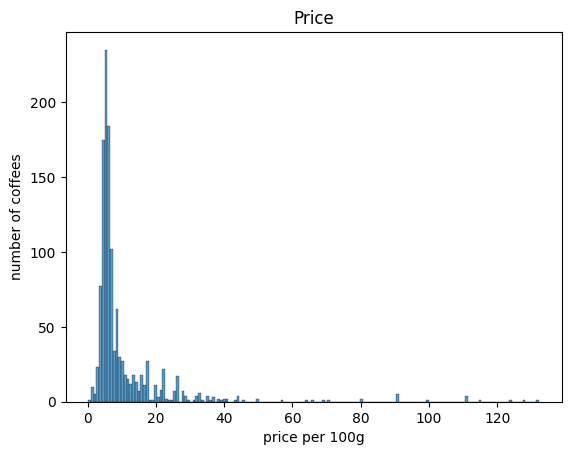

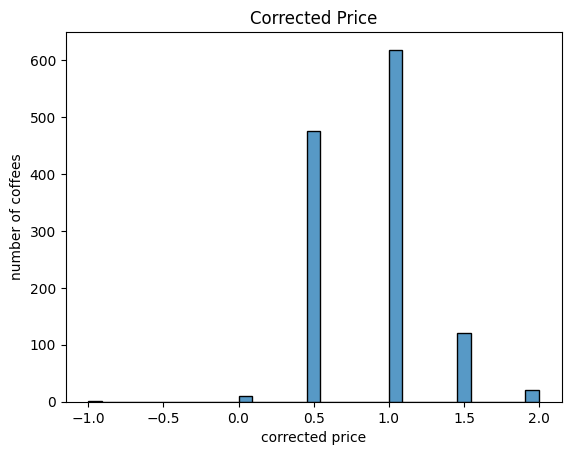

In [52]:
sns.histplot(data=data, x='100g_USD')
plt.title("Price")
plt.xlabel('price per 100g')
plt.ylabel('number of coffees')
plt.show()

sns.histplot(data=data, x='price')
plt.title("Corrected Price")
plt.xlabel('corrected price')
plt.ylabel('number of coffees')
plt.show()

##Machine Learning

In [55]:
y = data[main_label].values.reshape(-1,) #list of ratings
X = data.drop([main_label], axis=1) #other values
cat_cols = data.select_dtypes(include=['object']).columns #string columns - categorical features
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols] #index of categorical features
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.7, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((373, 7), (873, 7), (373,), (873,))

In [58]:
train_pool = Pool(X_train,
                  y_train,
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters
model = CatBoostRegressor(iterations=800,
                          depth=5,
                          verbose=0,
                          learning_rate=0.02,
                          loss_function='RMSE')

#train the model
model.fit(train_pool)
# make the prediction using the resulting model
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train: {round(rmse_train, 3)} points")
print(f"RMSE score for test: {round(rmse_test, 3)} points")

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f"R-squared score for train: {round(r2_train, 3)} points")
print(f"R-squared score for test: {round(r2_test, 3)} points")

RMSE score for train: 1.045 points
RMSE score for test: 1.244 points
R-squared score for train: 0.471 points
R-squared score for test: 0.307 points


Due to the poor RMSE and R-squared scores, we can determine that the data has low correlation between ratings and the categorical values ('roaster', 'roast', 'loc_country', 'origin', 'review_date'). This could be due to the subjective nature of ratings.